In [9]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl

from cryptic_rnn import *

# Functions

# RNN setup

In [15]:
## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 

def fully_trained_rnns(res):

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
   
    final_accs = pd.DataFrame({'train_acc': acc_train[-1,:], 'test_acc': acc_test[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc = fully_trained.test_acc
    fully_trained_idx = fully_trained.index
    
    final_accs = pd.DataFrame({'train_acc': acc_train_p[-1,:], 'test_acc_p': acc_test_p[-1,:]}) 
    fully_trained = final_accs[final_accs['train_acc'] == 1]
    ft_test_acc_p = fully_trained.test_acc_p
    fully_trained_idx_p = fully_trained.index
    
    ft_idx = list(fully_trained_idx_p.intersection(fully_trained_idx))
    
    ft_cue_dicts = [cue_dicts[i] for i in ft_idx]
    ft_tests = [tests[i] for i in ft_idx]
    ft_mods = [mods[i] for i in ft_idx]
    ft_mods_p = [mods_p[i] for i in ft_idx]
    
    return ft_mods, ft_mods_p, ft_tests, ft_cue_dicts, ft_test_acc, ft_test_acc_p 
    

def run_exp(trainseqs_old ,trainseqs_old_p, testseqs_old, cue_dict):

    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load data for primitive training
    trainseqs = change_dict(trainseqs_old_p, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_p = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs, hidden_size)
    
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset], epochs, hidden_size)
    
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test': testset,
           'loss_p':loss2, 'acc_p':acc2, 'mod_p': model_p}

def run_plot(trainseqs, trainseqs_p, testseqs, cue_dict):
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, trainseqs_p, testseqs, cue_dict) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    tests = [r['test'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    losses = np.hstack([r['loss'] for r in res])
    acc_train = np.array([r['acc'][:,0] for r in res]).T
    acc_test = np.array([r['acc'][:,1] for r in res]).T
    mods = [r['mod'] for r in res]
    losses_p = np.hstack([r['loss_p'] for r in res])
    acc_train_p = np.array([r['acc_p'][:,0] for r in res]).T
    acc_test_p = np.array([r['acc_p'][:,1] for r in res]).T
    mods_p = [r['mod_p'] for r in res]
    
    plotNNs([losses], [acc_train, acc_test], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'no pretraining', shift = 0)
    plotNNs([losses_p], [acc_train_p, acc_test_p], \
            ['train', 'test'], colors = ['green', 'orange'], title = 'with pretraining', shift = 0)
    
    acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_train_p': acc_train_p[-1,:],\
            'acc_test': acc_test[-1,:], 'acc_test_p': acc_test_p[-1,:]})
    
    return {'res':res, 'mods':mods, 'mods_p':mods_p, 'tests': tests, 'cue_dicts': cue_dicts, 'acc_df':acc_df }


In [16]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 12
num_sims = 8

# 
xavier_gain = 0.001

# Experiments

Final accuracy against ratio of other/self



In [17]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
print(primitives)

{'A': 9, 'B': 12, 'C': 5, 'D': 14}
[['A', '=', 9], ['B', '=', 12], ['C', '=', 5], ['D', '=', 14]]


# Run

trainseqs  [['A', ('+', 'A'), '=', 34], ['A', '=', 17], ['B', '=', 13], ['C', '=', 6], ['D', '=', 10]]
testseqs  [['A', ('+', 'A'), '=', 34], ['A', ('+', 'B'), '=', 30], ['A', ('+', 'C'), '=', 23], ['A', ('+', 'D'), '=', 27], ['B', ('+', 'A'), '=', 30], ['B', ('+', 'B'), '=', 26], ['B', ('+', 'C'), '=', 19], ['B', ('+', 'D'), '=', 23], ['C', ('+', 'A'), '=', 23], ['C', ('+', 'B'), '=', 19], ['C', ('+', 'C'), '=', 12], ['C', ('+', 'D'), '=', 16], ['D', ('+', 'A'), '=', 27], ['D', ('+', 'B'), '=', 23], ['D', ('+', 'C'), '=', 16], ['D', ('+', 'D'), '=', 20]]
run time:  0.07203988631566366
0
total time:  0.07358585198720297
0 / 8  rnns trained to 100% accuracy.        
 Mean test acc =  nan 
-----------



0

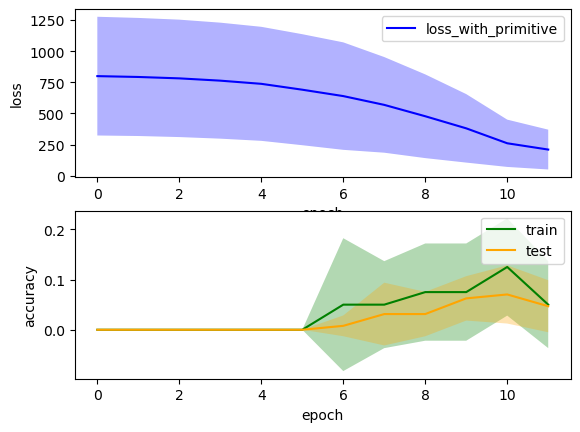

In [7]:
# other
epochs = 1500
num_sims = 640
#trainseqs = generate_trials(ops, all_syms, all_syms) + generate_other_reverse_primitives('+', all_syms)
trainseqs = generate_other(ops, all_syms)
trainseqs_p = generate_other(ops, all_syms) + primitives
testseqs = generate_trials(ops, all_syms, all_syms)
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res1 = run_plot(trainseqs, trainseqs_p, testseqs, cue_dict)

In [ ]:
# other - balanced
epochs = 2000
num_sims = 640
trainseqs = generate_other(ops, all_syms, cue_dict) + generate_other_reverse_primitives('+', all_syms, cue_dict)
trainseqs_p = generate_other(ops, all_syms, cue_dict) + primitives
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res2 = run_plot(trainseqs, trainseqs_p, testseqs, cue_dict)

trainseqs  [['A', ('+', 'B'), '=', 21], ['B', ('+', 'C'), '=', 17], ['C', ('+', 'D'), '=', 19], ['D', ('+', 'A'), '=', 23], ['A', ('+', 'C'), '=', 14], ['B', ('+', 'D'), '=', 26]]
testseqs  [['A', ('+', 'A'), '=', 18], ['A', ('+', 'B'), '=', 21], ['A', ('+', 'C'), '=', 14], ['A', ('+', 'D'), '=', 23], ['B', ('+', 'A'), '=', 21], ['B', ('+', 'B'), '=', 24], ['B', ('+', 'C'), '=', 17], ['B', ('+', 'D'), '=', 26], ['C', ('+', 'A'), '=', 14], ['C', ('+', 'B'), '=', 17], ['C', ('+', 'C'), '=', 10], ['C', ('+', 'D'), '=', 19], ['D', ('+', 'A'), '=', 23], ['D', ('+', 'B'), '=', 26], ['D', ('+', 'C'), '=', 19], ['D', ('+', 'D'), '=', 28]]


In [30]:
df = res2['acc_df']
df[(df['acc_train']==1)& (df['acc_train_p']==1)]

,acc_train,acc_train_p,acc_test,acc_test_p
2,1.0,1.0,1.0000,0.9375
3,1.0,1.0,0.6875,0.8750
5,1.0,1.0,0.6875,0.8750
8,1.0,1.0,0.6250,0.7500
9,1.0,1.0,1.0000,0.8750
...,...,...,...,...
628,1.0,1.0,1.0000,1.0000
630,1.0,1.0,0.6875,0.5625
633,1.0,1.0,1.0000,1.0000
636,1.0,1.0,0.5625,1.0000


In [19]:
# all
epochs = 1500
num_sims = 640
trainseqs = generate_trials(ops, all_syms, all_syms, cue_dict) + generate_other_reverse_primitives('+', all_syms, cue_dict)
trainseqs_p = generate_trials(ops, all_syms, all_syms, cue_dict) + primitives
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)
print('trainseqs ', trainseqs)
print('testseqs ', testseqs )
res3 = run_plot(trainseqs, trainseqs_p, testseqs, cue_dict)

TypeError: generate_other_reverse_primitives() missing 1 required positional argument: 'cue_dict'